<a href="https://colab.research.google.com/github/basselkassem/easy21/blob/master/linear_function_approx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libs

In [1]:
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=a0f292858abf656b008674bcf5def832d8e6e5b3915501a35c00f18d53e88a05
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [2]:
from google.colab import drive
drive.mount("/content/drive", )
%cd /content/drive/'My Drive'/'Colab Notebooks'/easy21

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/easy21


# Import Libs

In [3]:
import import_ipynb
import environment as env
import numpy as np
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt

importing Jupyter notebook from environment.ipynb


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Load optimal Q from MonteCarlo

In [0]:
Q_star = None
with open('q_optimal.pickle', 'rb') as file:
    Q_star = pickle.load(file)

# Implementation of LinearSarsa(λ):

We now consider a simple value function approximator using coarse coding. Use a binary feature vector φ(s; a) with 3 ∗ 6 ∗ 2 = 36 features. Each binary feature  has a value of 1 iff (s; a) lies within the cuboid of state-space corresponding to that feature, and the action corresponding to that feature. The cuboids have
the following overlapping intervals:
* dealer(s) = [1; 4]; [4; 7]; [7; 10]
* player(s) = [1; 6]; [4; 9]; [7; 12]; [10; 15]; [13; 18]; [16; 21]
*  a = hit; stick

where
* dealer(s) is the value of the dealer’s first card ( <= 10)
* sum(s) is the sum of the player’s cards (<= 21)

Repeat the Sarsa(λ) experiment from the previous section, but using linear value function approximation Q(s; a) = φ(s; a)T * θ.

Use a constant exploration of  = 0:05 and a constant step-size of 0:01. Plot the mean-squared error against λ. For λ = 0 and λ = 1 only, plot the learning curve of mean-squared error
against episode number.

In [0]:
class LinearSarsaLambda:
    def __init__(self, td_lambda, Q_star):
        features_num = 3 * 6 * 2
        self.Q = defaultdict(int)
        self.E = np.zeros((features_num))
        self.td_lambda = td_lambda
        self.STEP_SIZE =  0.01
        self.EXPLORATION_CONST = 0.05
        self.easy21 = env.Environment(mode = 'no_debug')
        self.Q_star = Q_star
        self.W = np.random.randn(features_num, 1)
    
    def epsilon_greedy(self, state):
        if np.random.random() < self.EXPLORATION_CONST:
            return self.easy21.sample_action()
        else:
            hit = self.Q[state, 0]
            stick = self.Q[state, 1]
            if hit > stick: 
                return 0
            if hit == stick:
                return self.easy21.sample_action()
            if hit < stick:
                return 1

    def agent_policy(self, state):
        return self.epsilon_greedy(state)

    def compute_Qsa(self, state, action):
        features = self.extract_features(state, action)
        Qhat = np.dot(features, self.W)
        return Qhat[0, 0]

    def policy_improvment(self, state, action):
        self.Q[state, action] = self.compute_Qsa(state, action) 
    
    def policy_evaluation(self, state, action):
        done = False
        next_action, td_error, Qhat = None, None, None
        while not done:
            next_state, reward, done = self.easy21.step(state, player_action = action)
            Qhat = self.compute_Qsa(state, action)
            if not done:
                next_action = self.agent_policy(next_state)
                nextQhat = self.compute_Qsa(next_state, next_action)
                td_error = reward + nextQhat - Qhat
            else:
                td_error = reward - Qhat

            dQhat = self.extract_features(state, action)
            self.E = self.td_lambda * self.E + dQhat.T
            self.W += self.STEP_SIZE * td_error * self.E
            self.policy_improvment(state, action)
            if not done:
                state, action = next_state, next_action
        
    def policy_iteration(self, episodes_num = 1000, episodes_error = False):
        errors = []
        for episode in range(episodes_num):
            self.E = np.zeros((36, 1))
            self.easy21 = env.Environment(mode = 'no_debug')
            state, _, done = self.easy21.init()
            action = self.agent_policy(state)
            self.policy_evaluation(state, action)
            if episodes_error == True:
                errors.append(self.compute_error(self.Q))
        if episodes_error == True:
            return errors
        else:
            return self.compute_error(self.Q)
    
    def compute_error(self, Q):
        error = 0
        for (state, action), value in self.Q_star.items():
            error += (value - Q[state, action]) ** 2
        return error / len(self.Q_star)             
        
    def extract_features(self, state, action):
        features = np.zeros((3 * 6 * 2))
        dealer_first_card, player_score = state
        dealer_ranges = [[1, 4], [4, 7], [7, 10]]
        player_ranges = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]
        for i, d_range in enumerate(dealer_ranges):
            if dealer_first_card in range(d_range[0], d_range[1] + 1): 
                features[i] = 1
        for j, p_range in enumerate(player_ranges, start=3):
            if player_score in range(p_range[0], p_range[1] + 1):
                features[j] = 1
        features[action - 2] = 1
        features = features.reshape((1, 3 * 6 * 2))
        return features

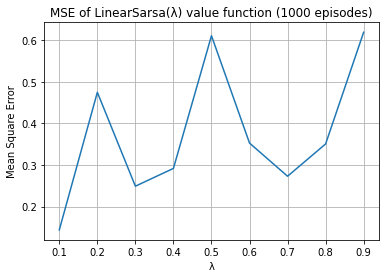

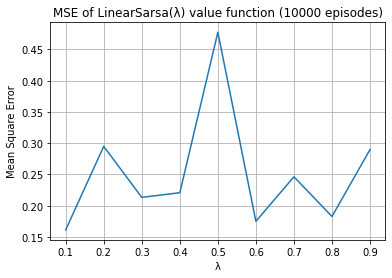

In [50]:
def mse_plot(episodes_num):
  mse_errors = []
  for lamb in env.TD_LAMBDA:
    agent = LinearSarsaLambda(lamb, Q_star)
    error = agent.policy_iteration(episodes_num = episodes_num)
    mse_errors.append(error)

  plt.plot(env.TD_LAMBDA, mse_errors)
  plt.xlabel('λ')
  plt.ylabel('Mean Square Error')
  plt.title('MSE of LinearSarsa(λ) value function ({} episodes)'.format(episodes_num))
  plt.grid(True)
  plt.show()
mse_plot(1000)
mse_plot(10000)

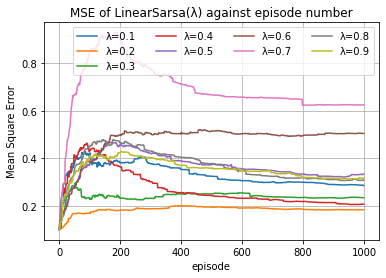

In [51]:
def mse_episodes_plot(td_lambda, episodes_num):
  for lamb in td_lambda:
    agent = LinearSarsaLambda(lamb, Q_star)
    errors = agent.policy_iteration(episodes_error = True, episodes_num = episodes_num)
    plt.plot(list(range(episodes_num)), errors)
  
  plt.legend(['λ={:0.1f}'.format(lamb) for lamb in td_lambda], ncol=4)
  plt.xlabel('episode')
  plt.ylabel('Mean Square Error')
  plt.title('MSE of LinearSarsa(λ) against episode number')
  plt.grid(True)
  plt.show()
mse_episodes_plot(env.TD_LAMBDA, 1000)

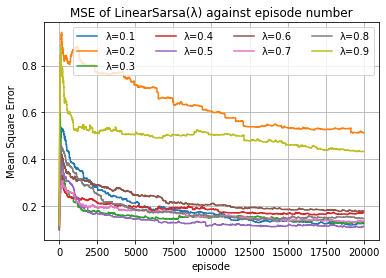

In [38]:
mse_episodes_plot(env.TD_LAMBDA, 20000)

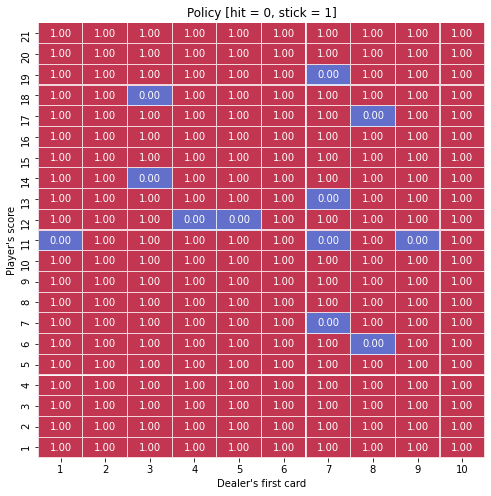

In [58]:
agent = LinearSarsaLambda(1, Q_star=Q_star)
agent.policy_iteration(episodes_num=2*10**6)
policy = np.zeros((env.MAX_VALUE, env.CARD_VALUE_MAX))
for ((d, p), action_ind), action in agent.Q.items():
    policy[p - 1, d - 1] = np.argmax([agent.Q[(d, p), 0], agent.Q[(d, p), 1]])
env.Visualizer.draw2d_array(policy, 'Policy [hit = 0, stick = 1]', True)

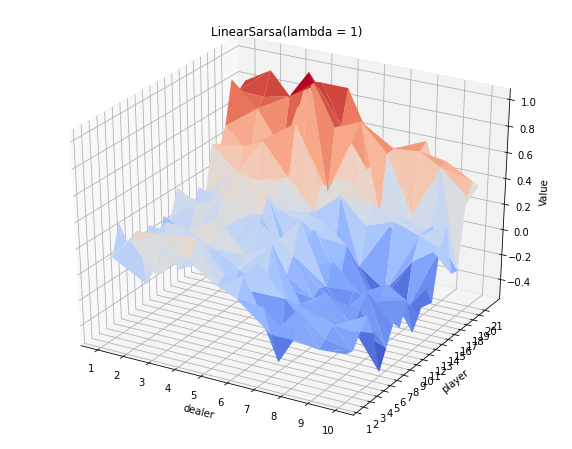

In [55]:
agent = LinearSarsaLambda(1, Q_star=Q_star)
agent.policy_iteration(episodes_num=10**5)
title = 'LinearSarsa(lambda = 1)'
env.Visualizer.visualize(agent.Q, title)

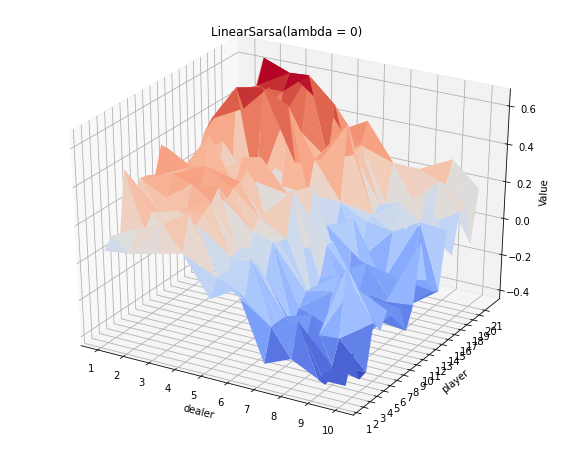

In [56]:
agent = LinearSarsaLambda(0, Q_star=Q_star)
agent.policy_iteration(episodes_num=10**5)
title = 'LinearSarsa(lambda = 0)'
env.Visualizer.visualize(agent.Q, title)